# 4.3 - Dropout, pooling

In [ ]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%load_ext tensorboard

from sklearn.datasets import *
from local.lib import mlutils
tf.__version__

'2.4.1'

## Dropout

Dropout is a sort of **regularization** See 

- [tf.keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)
- [An intuitive explanation of dropout](https://towardsdatascience.com/an-intuitive-explanation-to-dropout-749c7fb5395c)

We use a synthetic dataset

In [282]:
from sklearn.datasets import make_moons
X, y = make_moons(300, shuffle=True, noise=0.25)

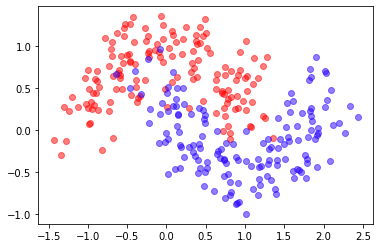

In [42]:
mlutils.plot_2Ddata(X,y)

In [119]:
def get_model(num_classes=2, nlayers=3, lsize=64, compile=True, dropout=None):
    print("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(2), name="input_1")
    
    layers = inputs
    for _ in range(nlayers):
        layers = tf.keras.layers.Dense(lsize, activation=tf.nn.relu)(layers)
        if dropout is not None:
            layers = tf.keras.layers.Dropout(dropout)(layers)
            
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

In [126]:
model = get_model()
model.summary()

using 2 classes
Model: "model_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_81 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_82 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_83 (Dense)             (None, 64)                4160      
_________________________________________________________________
output_1 (Dense)             (None, 2)                 130       
Total params: 8,642
Trainable params: 8,642
Non-trainable params: 0
_________________________________________________________________


In [127]:
model.fit(X, y, epochs=20, batch_size=8, verbose=False)
model.evaluate(X,y);

10/10 [==============================] - 0s 488us/step - loss: 0.1758 - accuracy: 0.9167


(0.52875, 0.47125)

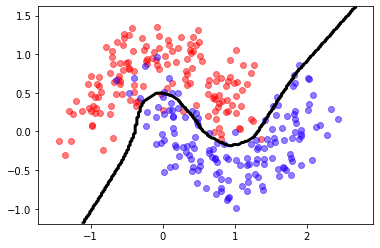

In [128]:
predict = lambda X: model.predict(X).argmax(axis=1)
mlutils.plot_2Ddata_with_boundary(predict, X,y)

In [132]:
model = get_model(dropout=0.3)
model.summary()

using 2 classes
Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_87 (Dense)             (None, 64)                192       
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_88 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_89 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)   

In [133]:
model.fit(X, y, epochs=20, batch_size=8, verbose=False)
model.evaluate(X,y);

10/10 [==============================] - 0s 513us/step - loss: 0.2144 - accuracy: 0.9167


(0.513225, 0.486775)

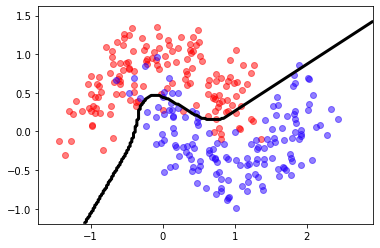

In [134]:
predict = lambda X: model.predict(X).argmax(axis=1)
mlutils.plot_2Ddata_with_boundary(predict, X,y)

In [135]:
model = get_model(nlayers=1, lsize=2, dropout=0.5)
model.summary()

using 2 classes
Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_90 (Dense)             (None, 2)                 6         
_________________________________________________________________
dropout_21 (Dropout)         (None, 2)                 0         
_________________________________________________________________
output_1 (Dense)             (None, 2)                 6         
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [136]:
model.fit(X, y, epochs=20, batch_size=8, verbose=False)
model.evaluate(X,y);

10/10 [==============================] - 0s 487us/step - loss: 0.5131 - accuracy: 0.7767


In [138]:
model.layers

observe the Dropout layer is used during training but has no weights

In [159]:
inp, l1, d, outp = model.layers
d.trainable, d.weights

(True, [])

but it is only used during training (default is `training=False`)

In [160]:
model(X[:2], training=False)

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.80517787, 0.19482216],
       [0.4387281 , 0.5612719 ]], dtype=float32)>

In [170]:
model(X[:2], training=True) # each execution may be different

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.94704497, 0.05295507],
       [0.48851433, 0.5114857 ]], dtype=float32)>

in inference a dropout layer is just a 1-to-1 mapping

In [267]:
tf.random.set_seed(0)
layer = tf.keras.layers.Dropout(.5, input_shape=(2,))
data = np.arange(1,11).reshape(5, 2).astype(np.float32)
print(data)


[[ 1.  2.]
 [ 3.  4.]
 [ 5.  6.]
 [ 7.  8.]
 [ 9. 10.]]


In [268]:
outputs = layer(data, training=False).numpy()
print(outputs)

[[ 1.  2.]
 [ 3.  4.]
 [ 5.  6.]
 [ 7.  8.]
 [ 9. 10.]]


in training dropout randomly drops inputs and normalizes. See [tf.keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)

In [276]:
outputs = layer(data, training=True).numpy()
print(outputs)

[[ 2.  0.]
 [ 6.  8.]
 [10. 12.]
 [ 0. 16.]
 [ 0.  0.]]


In [281]:
data[outputs!=0].sum() / layer.rate, outputs[outputs!=0].sum()

(54.0, 54.0)

## Pooling

In [285]:
!wget -nc https://s3.amazonaws.com/rlx/mini_cifar.h5
import h5py
with h5py.File('mini_cifar.h5','r') as h5f:
    x_cifar = h5f["x"][:]
    y_cifar = h5f["y"][:]
    
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_cifar, y_cifar, test_size=.25)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

File ‘mini_cifar.h5’ already there; not retrieving.

(2253, 32, 32, 3) (2253,) (751, 32, 32, 3) (751,)


In [295]:
def get_conv_model(num_classes=3, img_size=32, use_maxpooling=True, compile=True):
    print ("using",num_classes,"classes")
    inputs = tf.keras.Input(shape=(img_size,img_size,3), name="input_1")
    layers = tf.keras.layers.Conv2D(15,(5,5), activation="relu")(inputs)
    if use_maxpooling:
        layers = tf.keras.layers.MaxPool2D((2,2), name="pooling")(layers)
    layers = tf.keras.layers.Conv2D(60,(5,5), activation="relu")(layers)
    layers = tf.keras.layers.Flatten()(layers)
    layers = tf.keras.layers.Dense(16, activation=tf.nn.relu)(layers)
    layers = tf.keras.layers.Dropout(0.2)(layers)
    predictions = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax, name="output_1")(layers)
    model = tf.keras.Model(inputs = inputs, outputs=predictions)
    if compile:
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    return model

observe the size of the models with and without pooling

In [296]:
model = get_conv_model(use_maxpooling=False)
model.summary()

using 3 classes
Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 15)        1140      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 60)        22560     
_________________________________________________________________
flatten_4 (Flatten)          (None, 34560)             0         
_________________________________________________________________
dense_95 (Dense)             (None, 16)                552976    
_________________________________________________________________
dropout_32 (Dropout)         (None, 16)                0         
_________________________________________________________________
output_1 (Dense)             (None, 3)    

In [297]:
model = get_conv_model(use_maxpooling=True)
model.summary()

using 3 classes
Model: "model_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 28, 28, 15)        1140      
_________________________________________________________________
pooling (MaxPooling2D)       (None, 14, 14, 15)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 10, 60)        22560     
_________________________________________________________________
flatten_5 (Flatten)          (None, 6000)              0         
_________________________________________________________________
dense_96 (Dense)             (None, 16)                96016     
_________________________________________________________________
dropout_33 (Dropout)         (None, 16)   

observe the layer has no weights

In [303]:
p = model.get_layer('pooling')
p.trainable, p.weights

(True, [])

the layer can be applied anywhere there is a 2D structure

In [311]:
x_cifar[:1].shape, p(x_cifar[:1]).shape

((1, 32, 32, 3), TensorShape([1, 16, 16, 3]))

observe how the max is computed over each pixel and over each channel

In [328]:
# a random position
i,j = np.random.randint(16, size=2)*2

x_cifar[:1][0,i:i+2,j:j+2]

array([[[0.30980392, 0.28627451, 0.28235294],
        [0.01176471, 0.        , 0.00392157]],

       [[0.07843137, 0.0627451 , 0.05490196],
        [0.01568627, 0.00784314, 0.02352941]]])

In [329]:
p(x_cifar[:1])[0,i//2,j//2,:]

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.30980393, 0.28627452, 0.28235295], dtype=float32)>